In [109]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-churn-for-bank-customers/Churn_Modelling.csv


In [110]:
# data analysis libraries:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder

# data visualization libraries:
import matplotlib.pyplot as plt
import seaborn as sns

# to ignore warnings:
import warnings
warnings.filterwarnings('ignore')

# to display all columns:
pd.set_option('display.max_columns', None)

#timer
import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} done in {:.0f}s".format(title, time.time() - t0))

# Importing modelling libraries
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV

Importing Data

In [111]:
df = pd.read_csv('/kaggle/input/predicting-churn-for-bank-customers/Churn_Modelling.csv')

Explarotary Data Analysis

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [113]:
df = df.astype({"Age": float})
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0


In [114]:
df = df.astype({"Age": float})

In [115]:
df.shape

(10000, 14)

In [116]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

CATEGORICAL VARIABLES

In [117]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [118]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [119]:
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [120]:
df['HasCrCard'].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [121]:
df['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

In [122]:
df.groupby('IsActiveMember')['Exited'].value_counts()

IsActiveMember  Exited
0               0         3547
                1         1302
1               0         4416
                1          735
Name: Exited, dtype: int64

In [123]:
print('The ratio of retention of active members',end=": ")
print(round(4416/5151*100,2))
print('The ratio of retention of passive members',end=": ")
print(round(3547/4849*100,2))

The ratio of retention of active members: 85.73
The ratio of retention of passive members: 73.15


In [124]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [125]:
df.groupby('Gender')['Exited'].value_counts()

Gender  Exited
Female  0         3404
        1         1139
Male    0         4559
        1          898
Name: Exited, dtype: int64

In [126]:
print('The ratio of retention of men',end=": ")
print(round(4559/5457*100,2))
print('The ratio of retention of women',end=": ")
print(round(3404/4543*100,2))

The ratio of retention of men: 83.54
The ratio of retention of women: 74.93


A higher part of men seems to stay with the company, compared to women. 

In [127]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [128]:
df.groupby('Geography')['Exited'].value_counts()

Geography  Exited
France     0         4204
           1          810
Germany    0         1695
           1          814
Spain      0         2064
           1          413
Name: Exited, dtype: int64

In [129]:
print('The ratio of retention of customers from France',end=": ") 
print(round(4204/5014*100,2))
print('The ratio of retention of  customers from Spain',end=": ")
print(round(2064/2477*100,2))
print('The ratio of retention of customers from Germany',end=": ")
print(round(1695/2509*100,2))

The ratio of retention of customers from France: 83.85
The ratio of retention of  customers from Spain: 83.33
The ratio of retention of customers from Germany: 67.56


A higher part of customers from France and Spain seems to stay with the company, compared to Germany.

In [130]:
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [131]:
df.groupby('NumOfProducts')['Exited'].value_counts()

NumOfProducts  Exited
1              0         3675
               1         1409
2              0         4242
               1          348
3              1          220
               0           46
4              1           60
Name: Exited, dtype: int64

In [132]:
print('The ratio of retention of customers with 2 products',end=": ") 
print(round(4242/4590*100,2))
print('The ratio of retention of  customers with 1 product',end=": ")
print(round(3675/5084*100,2))

The ratio of retention of customers with 2 products: 92.42
The ratio of retention of  customers with 1 product: 72.29


A higher part of customers with 2 products seems to stay with the company, compared to customers with 1 product.

In [133]:
df['HasCrCard'].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [134]:
df.groupby('HasCrCard')['Exited'].value_counts()

HasCrCard  Exited
0          0         2332
           1          613
1          0         5631
           1         1424
Name: Exited, dtype: int64

In [135]:
print('The ratio of retention of customers with credit card',end=": ") 
print(round(2332/2945*100,2))
print('The ratio of retention of  customers without credit card',end=": ")
print(round(5631/7055*100,2))

The ratio of retention of customers with credit card: 79.19
The ratio of retention of  customers without credit card: 79.82


There is no significant difference between the customers who hold credit cards or not in terms of retention with the bank.

NUMERICAL VARIABLES

In [136]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


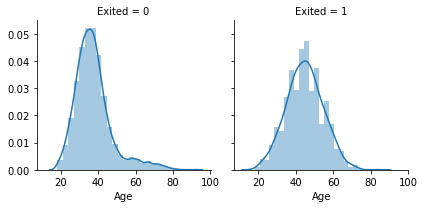

In [137]:
g = sns.FacetGrid(df, col = "Exited")
g.map(sns.distplot, "Age", bins = 25)
plt.show()

It seems younger customers tend to stick with the company more compared to older customers.

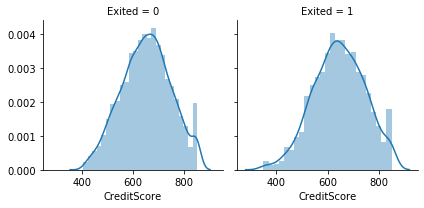

In [138]:
g = sns.FacetGrid(df, col = "Exited")
g.map(sns.distplot, "CreditScore", bins = 25)
plt.show()

It is interesting to see that there seems to be no relationship between credit score and exiting the company.

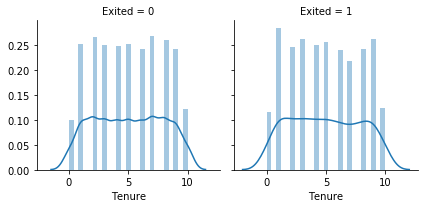

In [139]:
g = sns.FacetGrid(df, col = "Exited")
g.map(sns.distplot, "Tenure", bins = 25)
plt.show()

It is interesting to see that there seems to be no relationship between tenure and exiting the company.

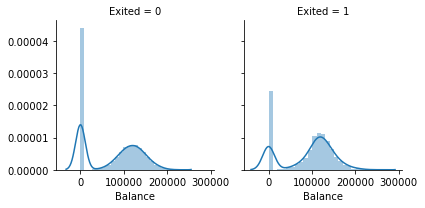

In [140]:
g = sns.FacetGrid(df, col = "Exited")
g.map(sns.distplot, "Balance", bins = 25)
plt.show()

It is interesting to see that there seems to be no relationship between balance and exiting the company.

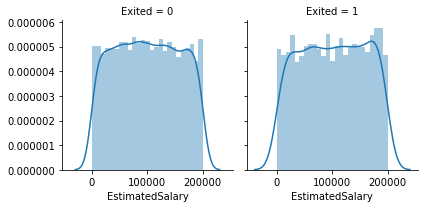

In [141]:
g = sns.FacetGrid(df, col = "Exited")
g.map(sns.distplot, "EstimatedSalary", bins = 25)
plt.show()

It is interesting to see that there seems to be no relationship between estimated salary and exiting the company.

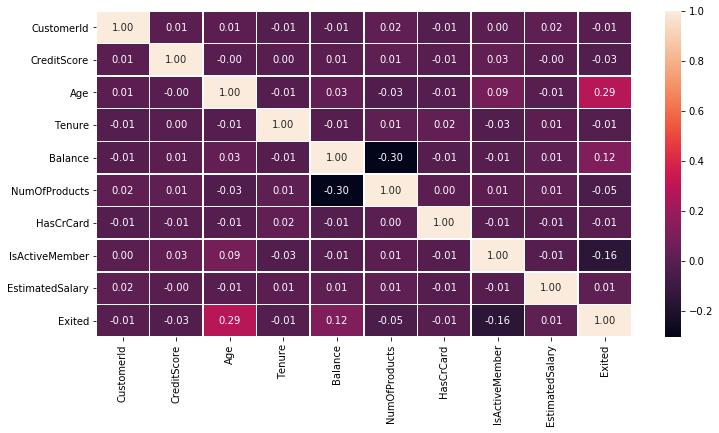

In [142]:
# Let's visualize the correlations between numerical features of data.
fig, ax = plt.subplots(figsize=(12,6)) 
sns.heatmap(df.iloc[:,1:len(df)].corr(), annot = True, fmt = ".2f", linewidths=0.5, ax=ax) 
plt.show()

As it can be seen from the figure there is no significant correlation among numerical variables. It seems that only the variable of Age has some kind of correlation with the variable of Exited.

Data Preparation

Dropping Certain Variables: RowNumber, Surname, CustomerId

In [143]:
df.drop(['RowNumber'], axis = 1, inplace = True)
df.drop(['Surname'], axis = 1, inplace = True)
df.drop(['CustomerId'], axis = 1, inplace = True)

In [144]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39.0,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0


Label encoding of the variable Gender to a dummy variable (0-1)

In [145]:
for d in [df]:
    d["Gender"]=d["Gender"].map(lambda x: 0 if x=='Female' else 1)

In [146]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42.0,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41.0,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42.0,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39.0,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43.0,2,125510.82,1,1,1,79084.10,0


One hot encoding of Tenure, Geography and NumOfProducts

In [147]:
df = pd.get_dummies(df, columns=["Tenure"])

In [148]:
df = pd.get_dummies(df, columns=["NumOfProducts"])

In [149]:
df = pd.get_dummies(df, columns=["Geography"])

In [150]:
df.head()

,CreditScore,Gender,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_0,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42.0,0.00,1,1,101348.88,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,608,0,41.0,83807.86,0,1,112542.58,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,502,0,42.0,159660.80,1,0,113931.57,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
3,699,0,39.0,0.00,0,0,93826.63,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,850,0,43.0,125510.82,1,1,79084.10,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


 Modeling, Evaluation and Model Tuning

Splitting the data as train and test

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
predictors = df.drop(['Exited'], axis=1)
target = df["Exited"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.20, random_state = 0)

In [152]:
x_train.shape

(8000, 25)

In [153]:
y_train.shape

(8000,)

In [154]:
y_train.head()

7389    0
9275    0
2995    0
5316    0
356     0
Name: Exited, dtype: int64

In [155]:
x_val.shape

(2000, 25)

Accuracy Scores for the Default models

In [156]:
r=1309
models = [LogisticRegression(random_state=r),GaussianNB(), KNeighborsClassifier(),
          SVC(random_state=r,probability=True),DecisionTreeClassifier(random_state=r),
          RandomForestClassifier(random_state=r), GradientBoostingClassifier(random_state=r),
          XGBClassifier(random_state=r), MLPClassifier(random_state=r),
          CatBoostClassifier(random_state=r,verbose = False)]
names = ["LogisticRegression","GaussianNB","KNN","SVC",
             "DecisionTree","Random_Forest","GBM","XGBoost","Art.Neural_Network","CatBoost"]

In [157]:
print('Default model validation accuracies for the train data:', end = "\n\n")
for name, model in zip(names, models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val) 
    print(name,':',"%.3f" % accuracy_score(y_pred, y_val))

Default model validation accuracies for the train data:

LogisticRegression : 0.814
GaussianNB : 0.785
KNN : 0.764
SVC : 0.797
DecisionTree : 0.797
Random_Forest : 0.869
GBM : 0.868
XGBoost : 0.846
Art.Neural_Network : 0.790
CatBoost : 0.864


Cross Validation Accuracy Scores of the Default Models

In [158]:
results = []
print('10 fold cross validation accuracy scores of the default models:', end = "\n\n")
for name, model in zip(names, models):
    kfold = KFold(n_splits=10, random_state=1001)
    cv_results = cross_val_score(model, predictors, target, cv = kfold, scoring = "accuracy")
    results.append(cv_results)
    print("{}: {} ({})".format(name, "%.3f" % cv_results.mean() ,"%.3f" %  cv_results.std()))

10 fold cross validation accuracy scores of the default models:

LogisticRegression: 0.790 (0.007)
GaussianNB: 0.786 (0.007)
KNN: 0.765 (0.009)
SVC: 0.796 (0.010)
DecisionTree: 0.788 (0.010)
Random_Forest: 0.861 (0.009)
GBM: 0.864 (0.009)
XGBoost: 0.854 (0.008)
Art.Neural_Network: 0.712 (0.081)
CatBoost: 0.866 (0.008)


Model tuning using crossvalidation

In [162]:
# Tuning by Cross Validation  
rf_params = {"max_features": ["log2","Auto","None"],
                "min_samples_split":[2,3,5],
                "min_samples_leaf":[1,3,5],
                "bootstrap":[True,False],
                "n_estimators":[50,100,150],
                "criterion":["gini","entropy"]}
rf = RandomForestClassifier()
rf_cv_model = GridSearchCV(rf, rf_params, cv = 5, n_jobs = -1, verbose = 2)
rf_cv_model.fit(x_train, y_train)
rf_cv_model.best_params_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  4.3min finished


{'bootstrap': True,
 'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 100}

In [165]:
rf = RandomForestClassifier(bootstrap = True, criterion = 'entropy' , max_features = 'log2', min_samples_leaf = 3, min_samples_split = 3,
 n_estimators = 100)
rf_tuned = rf.fit(x_train,y_train)
y_pred = rf_tuned.predict(x_val) 
acc_rf = round(accuracy_score(y_pred, y_val) * 100, 2) 
print(acc_rf)

86.55


In [166]:
predictions = y_pred

In [167]:
output = pd.DataFrame({ 'Exited': predictions }) 
output.to_csv('submission.csv', index=False)
output.head()

,Exited
0,0
1,0
2,0
3,0
4,0


In [168]:
output.describe().T

,count,mean,std,min,25%,50%,75%,max
Exited,2000.0,0.133,0.33966,0.0,0.0,0.0,0.0,1.0


In [170]:
output["Exited"].value_counts()

0    1734
1     266
Name: Exited, dtype: int64

In [171]:
Retention_Rate = 1734/2000*100

In [172]:
print(str(Retention_Rate)+'%')

86.7%
